<a href="https://colab.research.google.com/github/statscol/glob_test_ds/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TEST GLOBANT DATA-SCIENTIST**<br><br>
Jhon Parra <br> 
Contact:<br>
jhonparra939@gmail.com <br>
linkedin.com/in/jfparra/



#Diabetes

### 1. Context and Approach

For this case we need to find a way to determine if, given certain conditions, Diabetes-diagnosed patients will be readmitted to the Hospital in less than 30 days, readmitted in more than 30 days or definitely not readmitted at all. So its a multi-class classification problem and we'll adress it using the following procedures.


<center>
<img src='https://drive.google.com/uc?id=1SkKcGwMqv4Z7JWuymjM7IuVPzSquumZ6'>
</center>




Lets download and read the data ...


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip
!unzip dataset_diabetes.zip

--2021-08-01 16:36:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3347213 (3.2M) [application/x-httpd-php]
Saving to: ‘dataset_diabetes.zip’

dataset_diabetes.zi 100%[===================>]   3.19M  --.-KB/s    in 0.08s   

2021-08-01 16:36:29 (39.9 MB/s) - ‘dataset_diabetes.zip’ saved [3347213/3347213]

Archive:  dataset_diabetes.zip
  inflating: dataset_diabetes/diabetic_data.csv  
  inflating: dataset_diabetes/IDs_mapping.csv  


In [ ]:
#Libraries required
#Read Data
import pandas as pd
import numpy as np

data=pd.read_csv("/content/dataset_diabetes/diabetic_data.csv",na_values=["?",""])
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


###2. Data Cleaning and Wrangling
Given that some columns that were meant to be numerical have strings somewhere. Pandas assumes its a text/String column. We need to change this and set those string values to null.



In [ ]:
##admission_type_id, discharge_disposition_id and admission_source_id	are not an integer but a category
##

data['admission_type_id']=data.admission_type_id.astype(str)
data['discharge_disposition_id']=data.discharge_disposition_id.astype(str)
data['admission_source_id']=data.admission_source_id.astype(str)


##variables diag_1 to diag_3 are not strings but floats
data['diag_1']=pd.to_numeric(data.diag_1,errors='coerce')
data['diag_2']=pd.to_numeric(data.diag_2,errors='coerce')
data['diag_3']=pd.to_numeric(data.diag_3,errors='coerce')



Some variables like weight have more than 96% of missing values. So for this test we'll exclude it from the analysis. Even though medical_specialty has about 50% of missing values, there could be key information which might lead to explan the variable of interest, so for now we'll keep it in the dataset. Lets also drop other columns not needed.

In [ ]:
##check null values
data.drop(columns=['weight','encounter_id','patient_nbr'],inplace=True)
100*(np.sum(data.isnull(),axis=0)/data.shape[0])


race                         2.233555
gender                       0.000000
age                          0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       1.637089
diag_2                       2.843779
diag_3                       6.368532
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride                  0.000000
acetohexamid

One thing to consider for a predictive model, is to check if the target variable is balanced. Fortunately, this data doesnt seem to be way to imbalanced. However, we will need to consider a metric which is not sensitive to this kind of problem such as Kohen's Kappa. An undersampling of the majority classes could also be useful or robust strategies such as AdaSyn or Smote to balance minority classes generating synthetic records.

In [ ]:
##target variable cases (%)
100*data.readmitted.value_counts()/data.shape[0]

NO     53.911916
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64

In [ ]:
#For this test we'll undersample the majority class in 10%
readmitted_no=data[data['readmitted']=="NO"].sample(frac=0.9)
print("[INFO] Rows readmitted=NO : {}".format(data[data['readmitted']=="NO"].shape[0]))
print("[INFO] Rows readmitted=NO after downsample: {}".format(readmitted_no.shape[0]))
data_rs=pd.concat((data[data['readmitted']!="NO"],readmitted_no),axis=0)
print("[INFO] Rows Downsampled Dataset: {}".format(data_rs.shape[0]))

print("====New Target Variable Distribution===\n {}".format(100*data_rs.readmitted.value_counts()/data.shape[0]))

[INFO] Rows readmitted=NO : 54864
[INFO] Rows readmitted=NO after downsample: 49378
[INFO] Rows Downsampled Dataset: 96280
====New Target Variable Distribution===
 NO     48.521117
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64


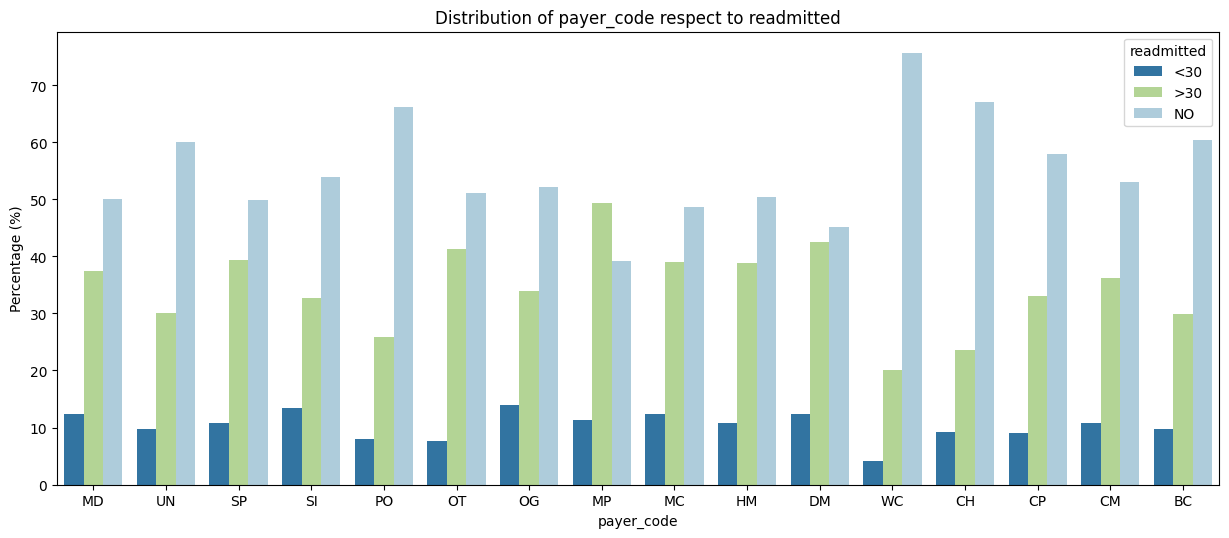

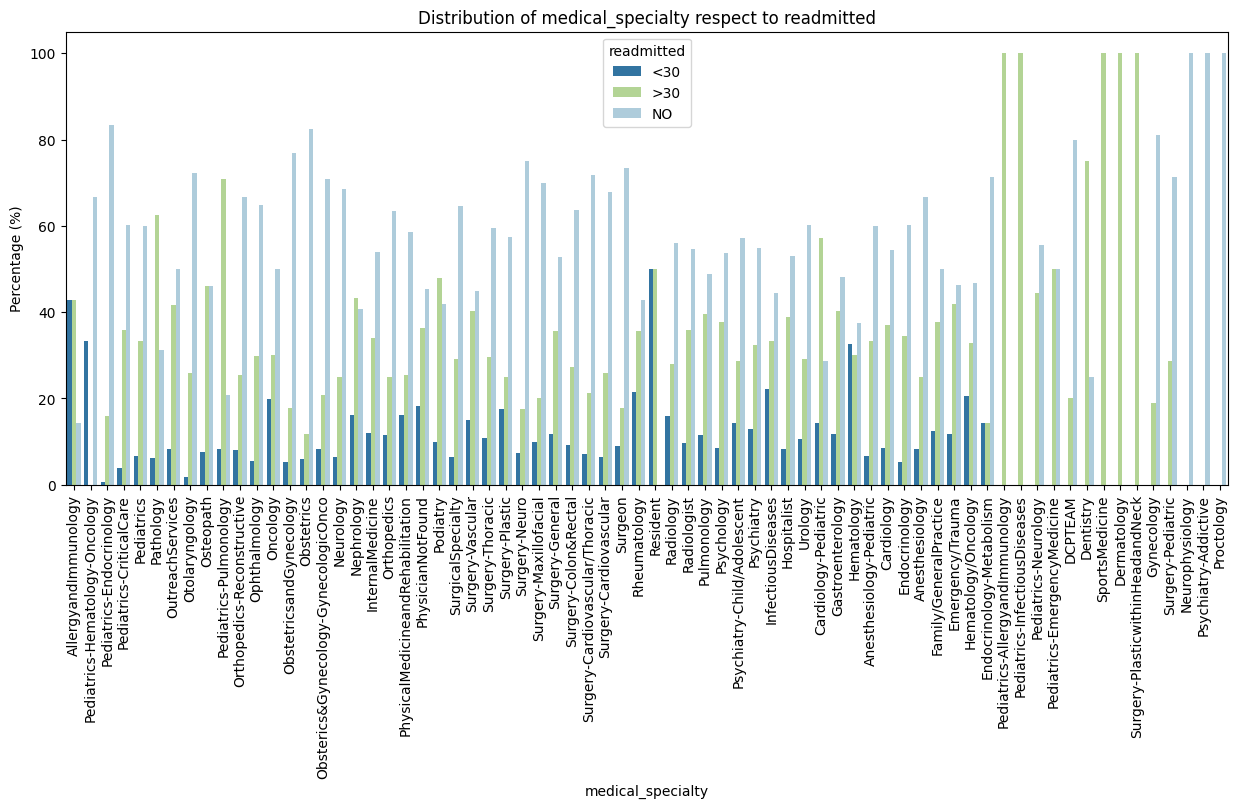

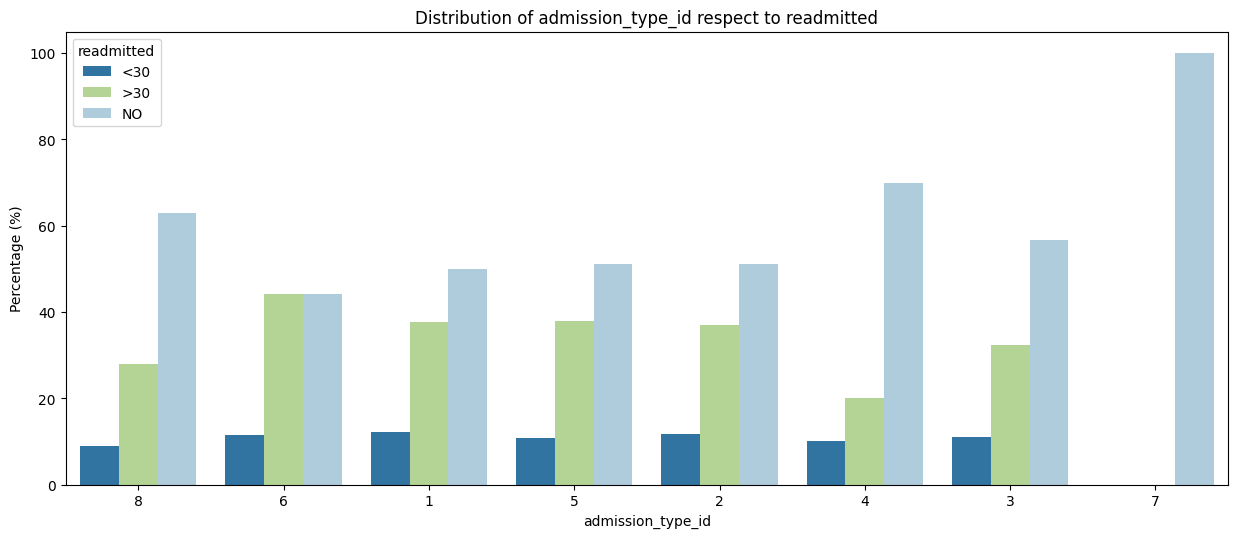

In [ ]:
## Now lets check if some of the cateogrical variables contribute when trying to predict the outcome of a patient with Diabetes once he/she leaves the hospital.
## Seems like we could find significant insights if we consider payer_code, medical_specialty or admission_type_id to predict readmission.

import matplotlib.pyplot as plt
import seaborn as sns

def get_grouped_plot(col1,rotation=0):
  dataagrup=data_rs.groupby([col1])['readmitted'].value_counts(normalize=True)\
                     .rename('percentage')\
                     .mul(100)\
                     .reset_index()\
                     .sort_values('readmitted')

  f,ax=plt.subplots(figsize=(15,6),dpi=100)
  g=sns.barplot(data=dataagrup,x=col1,y='percentage',hue='readmitted',ax=ax,palette={'NO':sns.color_palette("Paired")[0], '<30': sns.color_palette("Paired")[1], '>30': sns.color_palette("Paired")[2]})
  ax.set_title("Distribution of {} respect to readmitted".format(col1))
  ax.set_ylabel("Percentage (%)")
  plt.xticks(rotation=rotation)
  f.show()


get_grouped_plot('payer_code')
 
get_grouped_plot('medical_specialty',rotation=90)

get_grouped_plot('admission_type_id')



### 3. Model Training and Data Pipeline

Given that we have plenty of categorical variables with many categories and that its interactions might lead to predict readmission more accurately, we could use a CatBoost model which have a special strategy to encode categorical features based on a random permutation for its expected value. This algorithm is known for its performance and state-of-the-art results.

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 5.2 kB/s 


In [ ]:
##replace target variable for integers
data_rs['readmitted'].replace({'NO':0,'<30':1,'>30':2},inplace=True)


In [ ]:
##Generate Train & test data
from sklearn.model_selection import train_test_split,GridSearchCV

X_train,X_test,Y_train,Y_test = train_test_split(data_rs.drop(columns=['readmitted']),data_rs['readmitted'], test_size=0.3, random_state=143,stratify=data_rs['readmitted'])

Lets train the model, given computational resources and time required to train it and test a grid of parameters, we'll only consider a Cross Validation search for iterations and depth

In [ ]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn_pandas import DataFrameMapper
from datetime import datetime 
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score,precision_score,recall_score,make_scorer
import time

##lets take into account how much time it takes to train the model
init_time=datetime.now() 


categorical_features = X_train.select_dtypes(include=[np.object]).columns.values.tolist()
categorical_transformer = SimpleImputer(strategy='most_frequent')


numeric_features = X_train.drop(columns=categorical_features).columns.values.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

preprocessor=FeatureUnion([
              ('num',ColumnTransformer([
               ('step1',numeric_transformer,numeric_features)])),
              ('cat',ColumnTransformer([
               ('step2',categorical_transformer,categorical_features)]))  ])
              
###once numeric transformer and categorical transformer return data, index for categorical variables will start where numeric variables index ends
model=CatBoostClassifier(cat_features=[i for i in range(len(numeric_features),X_train.shape[1])],metric_period=500)
pipeline_catboost = Pipeline(
    steps=[
      ("prep", preprocessor),
      ("catboost", model)
        ])


##lets define a grid search for iterations and depth
params={'catboost__iterations':[50,100,150],
        'catboost__depth':[4,7,10]
        }
## Define a scoring method to evaluate performance of cross-validation models
scoring={'kappa':make_scorer(cohen_kappa_score),'accuracy':'accuracy'}
grid= GridSearchCV(pipeline_catboost, params,scoring=scoring,refit='kappa',n_jobs=-1)
grid.fit(X_train,Y_train)

print("[SUCCESS] Elapsed time for GridSearch Cross Validation : {:.2f} Minutes\n".format((datetime.now()-init_time).total_seconds()/60))
print("[INFO] BEST PARAMS FOUND: ")
print(grid.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Learning rate set to 0.5
0:	learn: 0.9792772	total: 601ms	remaining: 29.5s
49:	learn: 0.8504656	total: 24.4s	remaining: 0us
[SUCCESS] Elapsed time for GridSearch Cross Validation : 37.43 Minutes

[INFO] BEST PARAMS FOUND: 
{'catboost__depth': 7, 'catboost__iterations': 50}


In [ ]:

##predict on train and test set to compute performance metrics
y_train=grid.predict(X_train)
y_test=grid.predict(X_test)


### Lets define a strategy to validate model performance on a multi-class classification problem.

Seems like the best model for the parameter grid provided, had some problems when trying to predict if a patient will be readmitted after 30 days based on the Cohen's Kappa score for the test set. However, it can be useful to predict the remaining classes of the target variable.  

In [ ]:
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score,precision_score,recall_score,make_scorer
def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  prec=precision_score(real,pred)
  recall=recall_score(real,pred)

  print (f" Accuracy:{acc:.4f} \n Precision: {prec:.4f} \n Recall: {recall:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f} ")

def norm_multivector(pred_vec,truth_vec,clase):
  aux_ypre=[1 if x==clase else 0 for x in pred_vec]
  aux_ytruth=[1 if x==clase else 0 for x in truth_vec]
  return aux_ypre,aux_ytruth

unique_classes=np.sort(data_rs['readmitted'].value_counts().index.values.tolist())
readmission_classes=len(unique_classes)

print("======Metrics for TRAIN DATA=======\n\n")
for i in range(readmission_classes):
  print(f"Results for: {unique_classes[i]} in test set")
  v1,v2=norm_multivector(Y_train,y_train,clase=i)
  metrics(v1,v2)
print("============================================")

print("======Metrics for TEST DATA=======\n\n")
for i in range(readmission_classes):
  print(f"Results for: {unique_classes[i]} in test set")
  v1,v2=norm_multivector(Y_test,y_test,clase=i)
  metrics(v1,v2)
print("============================================")


======Metrics for TRAIN DATA=======


Results for: 0 in test set
 Accuracy:0.6504 
 Precision: 0.6220 
 Recall: 0.8116 
 Kappa: 0.2946 
 F1-Score: 0.7042 
Results for: 1 in test set
 Accuracy:0.8842 
 Precision: 0.6000 
 Recall: 0.0543 
 Kappa: 0.0817 
 F1-Score: 0.0997 
Results for: 2 in test set
 Accuracy:0.6593 
 Precision: 0.5445 
 Recall: 0.4720 
 Kappa: 0.2477 
 F1-Score: 0.5057 
======Metrics for TEST DATA=======


Results for: 0 in test set
 Accuracy:0.6310 
 Precision: 0.6070 
 Recall: 0.7955 
 Kappa: 0.2555 
 F1-Score: 0.6886 
Results for: 1 in test set
 Accuracy:0.8789 
 Precision: 0.3583 
 Recall: 0.0338 
 Kappa: 0.0422 
 F1-Score: 0.0617 
Results for: 2 in test set
 Accuracy:0.6395 
 Precision: 0.5137 
 Recall: 0.4408 
 Kappa: 0.2026 
 F1-Score: 0.4745 


### 4. Final Comments and Further Work


We have found a way to detect whether or not a Diabetes-diagnosed patient will be readmitted at the hospital by using a machine learning algorithm. This model could be improved by setting a more extensive grid search for its parameters or more feature enginnering. Also we could try another algorithm and stack them up in order to compare different methods or to just use a stacking approach, where our goal is to predict our variable of interest, using the output of many algorithms only.